# Stability of feature selection with regularized methods

In this tutorial, we will explore the concept of _'stability'_ of a feature selection algorithm. The term here refers to the robustness of its feature preferences, with respect to data sampling.  We can say that feature has high stability if multiple feature selection repetitions “agree” that this feature is important and low stability when multiple feature selection processes  “disagree” that this feature is important.  

Stability is not always easy to achieve, especially in the real world data, but it is extremely important to analyse when selecting features. Having a stable set of features is a proxy for _reproducible research_, especially in the biomedical field (e.g. which genes that algorithm selected are likely to be a data artefact and not a real clinical signal worth pursuing further?)

______________________________

Let's start! As always, we first load the packages we need:

**TBA**: Reference to Noguiera tutorial/paper!

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics._scorer import make_scorer
from sklearn.metrics import balanced_accuracy_score, accuracy_score
import stability as st
from utils_ import getBootstrapSample
import matplotlib.pyplot as plt
from tqdm import tqdm

## Data loading

Here we just load the data we preprocessed in the data_preprocessing.ipynb. Recall, this is the gene expression dataset with... **TBA**

**NOTE** - currently the results show the breast cancer dataset as they are much better to showcase what we want!

In [2]:
data = pd.read_csv("./data/tomatos_with_targets.txt", index_col=0)
#data = pd.read_csv("./data/breast_cancer.csv")
data.head()

,Solyc02g081130.1.1,Solyc12g038200.1.1,Solyc00g097760.1.1,Solyc08g069180.2.1,Solyc01g012570.1.1,Solyc08g076670.2.1,Solyc04g024840.2.1,Solyc09g074310.2.1,Solyc09g005370.1.1,Solyc12g098180.1.1,...,Solyc01g088670.1.1,Solyc06g063380.1.1,Solyc10g050450.1.1,Solyc07g051990.1.1,Solyc02g093490.2.1,Solyc10g007270.2.1,species,position,tissue,root
penn.Sh.floral,1.169216,0.000000,0.0,1.305753,0.0,4.634343,2.860965,3.242561,0.0,0.0,...,2.120579,0.0,0.000000,0.0,5.027894,0.0,penn,Sh,floral,0
penn.Sh.leaf,0.000000,0.858644,0.0,2.948383,0.0,4.653912,2.241161,2.922573,0.0,0.0,...,1.370140,0.0,2.006256,0.0,5.068390,0.0,penn,Sh,leaf,0
penn.Sh.root,0.000000,0.000000,0.0,0.469958,0.0,5.798938,3.217704,2.229663,0.0,0.0,...,1.970763,0.0,1.688588,0.0,4.889667,0.0,penn,Sh,root,1
penn.Sh.sdling,1.813992,0.000000,0.0,2.586147,0.0,4.771861,3.099842,3.452604,0.0,0.0,...,1.982446,0.0,1.651062,0.0,3.105620,0.0,penn,Sh,sdling,0
penn.Sh.stem,0.000000,0.000000,0.0,1.540887,0.0,4.907770,4.800873,1.973890,0.0,0.0,...,1.452937,0.0,0.000000,0.0,4.993720,0.0,penn,Sh,stem,0


## Setup

...If tomato dataset: 
We extracted multiple targets from the dataset and here we want to choose which one we decide to model and we discard the rest.

In [3]:
# Choose the target
target = 'species'
#target = 'target'

# Targets
potential_targets = ['species','position','tissue','root']
#potential_targets = []
# Remove other potential targets
drop = list(set(potential_targets) - set([target]))
data_model = data.drop(columns = drop, axis = 1)
data_model.head()

# Save only feature column names:
feature_columns =  data_model.drop(columns=[target], axis=1).columns

# Save X and y separately
X = data_model.drop(target, axis=1)
y = data_model[target]

Encode the labels: our labels are categorical and we need to encode them to have integer values. 

Scale the data: Regression models benefit from scaling the data.

In [4]:
# Encode labels if it is classification
encoder = LabelEncoder()
y = encoder.fit_transform(y)
print(np.unique(data_model[target], return_counts=True))
print(np.unique(y, return_counts=True))
#Scale the data
scaler = StandardScaler()
X_transformed = scaler.fit_transform(X)

(array(['M82', 'penn'], dtype=object), array([12, 12]))
(array([0, 1]), array([12, 12]))


In [32]:
X_transformed[:5,:5]

array([[ 0.81415875, -0.35024209, -0.20851441, -0.27482876,  0.        ],
       [-1.03764141,  3.68690371, -0.20851441,  1.72916449,  0.        ],
       [-1.03764141, -0.35024209, -0.20851441, -1.2944904 ,  0.        ],
       [ 1.835353  , -0.35024209, -0.20851441,  1.28724006,  0.        ],
       [-1.03764141, -0.35024209, -0.20851441,  0.01203308,  0.        ]])

## Modeling without taking stability into account
Elastic net regression on the full dataset - How it is usually done? Usually, the lambda maximizing the accuracy is taken,...

In [5]:
# Just for now..can't get elastic net to run w/o the convergence error 
import warnings
warnings.filterwarnings('ignore')

Define the model:

In [6]:
# model = LogisticRegression(penalty='l1', solver='liblinear',max_iter=300)
# model_name = 'lasso'
model = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.5, max_iter=2000)
model_name = 'elasticnet'

Define the grid for the hyperparameter search:

In [7]:
num_lambdas = 10 # We will test 10 parameters
lambdas = np.linspace(-2,0,num_lambdas).astype(float)
lambdas=np.power(10,lambdas)
hyper_grid = {'C': lambdas}
hyper_grid


{'C': array([0.01      , 0.01668101, 0.02782559, 0.04641589, 0.07742637,
        0.12915497, 0.21544347, 0.35938137, 0.59948425, 1.        ])}

Find the optimal parameter for Lasso:

In [8]:
# Define a grid search with 10-fold CV and fit 
gridsearch_classifier = GridSearchCV(model, hyper_grid, cv=StratifiedKFold(n_splits=4), verbose=1, scoring='accuracy')
gridsearch_classifier.fit(X_transformed, y)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=LogisticRegression(l1_ratio=0.5, max_iter=2000,
                                          penalty='elasticnet', solver='saga'),
             param_grid={'C': array([0.01      , 0.01668101, 0.02782559, 0.04641589, 0.07742637,
       0.12915497, 0.21544347, 0.35938137, 0.59948425, 1.        ])},
             scoring='accuracy', verbose=1)

In [9]:
print(gridsearch_classifier.cv_results_['params'])
print(f"Average accuracy: {round(np.mean(gridsearch_classifier.cv_results_['mean_test_score'])*100,2)}%")

C = gridsearch_classifier.best_params_
print(f"Chosen parameter {C}")

[{'C': 0.01}, {'C': 0.016681005372000592}, {'C': 0.027825594022071243}, {'C': 0.046415888336127774}, {'C': 0.0774263682681127}, {'C': 0.1291549665014884}, {'C': 0.21544346900318834}, {'C': 0.3593813663804626}, {'C': 0.5994842503189409}, {'C': 1.0}]
Average accuracy: 80.0%
Chosen parameter {'C': 0.0774263682681127}


## Stability analysis
### Optimizing Stability and Accuracy of Regularized Methods

TODO - write how the stability measure is defined, reference the paper, write properties the stability metric should have

In [10]:
M = 10
d = X.shape[1]
Z=np.zeros((num_lambdas,M,d),dtype=np.int8)
errors=np.zeros((M,num_lambdas))
stabilities=np.zeros(num_lambdas)
errStab=np.zeros(num_lambdas)
numFeatSelected=np.zeros((M,num_lambdas),dtype=np.int32)

We apply L1-logistic regression with different regularizing parameters lambda on M bootstrap samples of the data using the scikit-learn package. We report the stability as given in [1] and the average out-of-bag (OOB) error over the M repeats.



In [11]:
## for each repeat
for i in tqdm(range(M)):
    newData=getBootstrapSample(np.asarray(X_transformed),np.asarray(y), random_state=(i+1)*10+1234) ## we get a bootstrap sample
    for k in range(num_lambdas):
        logistic = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.5, C=lambdas[k], max_iter=2000, random_state=(i+1)*10+12345)
        logistic.fit(newData['bootData'],newData['bootLabels'])  ## we fit the coefficients 
        Z[k,i,:]=sum(logistic.coef_!=0)
        numFeatSelected[i,k]=sum(sum(logistic.coef_!=0))
        predLabels=logistic.predict(newData['OOBData'])
        errors[i,k]=1-accuracy_score(newData['OOBLabels'], predLabels)
meanError=np.mean(errors,0)
#errCI=norm.ppf(1-alpha/2)*(np.std(errors,0))/math.sqrt(M)

100%|██████████| 10/10 [09:33<00:00, 57.39s/it]


To better understand what is saved in each object, let's check their size and how the results look like:

In [12]:
print(f'Errors shape: {errors.shape}')
print(f'numFeatSelected shape: {numFeatSelected.shape}')
print(f'Z shape: {Z.shape}')

Z_dict = {}
for i in range(Z.shape[0]):
    Z_dict[lambdas[i]] = pd.DataFrame(Z[i, :,:], columns=X.columns)

index = 0
print(f'For lambda = {lambdas[index]}, results look like follows:')
Z_dict[lambdas[index]].head()

Errors shape: (10, 10)
numFeatSelected shape: (10, 10)
Z shape: (10, 10, 28298)
For lambda = 0.01, results look like follows:


,Solyc02g081130.1.1,Solyc12g038200.1.1,Solyc00g097760.1.1,Solyc08g069180.2.1,Solyc01g012570.1.1,Solyc08g076670.2.1,Solyc04g024840.2.1,Solyc09g074310.2.1,Solyc09g005370.1.1,Solyc12g098180.1.1,...,Solyc02g094560.2.1,Solyc09g091640.1.1,Solyc01g099290.2.1,Solyc07g008430.1.1,Solyc01g088670.1.1,Solyc06g063380.1.1,Solyc10g050450.1.1,Solyc07g051990.1.1,Solyc02g093490.2.1,Solyc10g007270.2.1
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


TODO - explain a bit the result (e.g. feature 1 was chosen in iterations 1,2,3, but not in 4 etc)

Now let's see how does lambda affect the number of features selected:

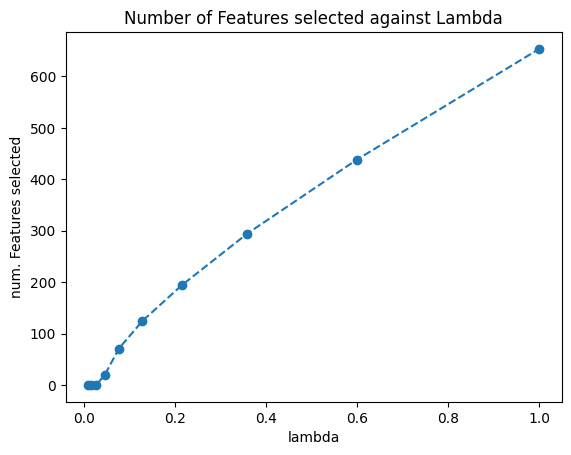

In [13]:
plt.close()
plt.figure()
plt.plot(lambdas,np.mean(numFeatSelected,0),marker='o', linestyle='--')
plt.xlabel('lambda')
plt.ylabel('num. Features selected')
plt.title('Number of Features selected against Lambda')
plt.show()

As we expect, the number of features selected decreases as we increase the regularization.
Let us now plot the average OOB error against lambda

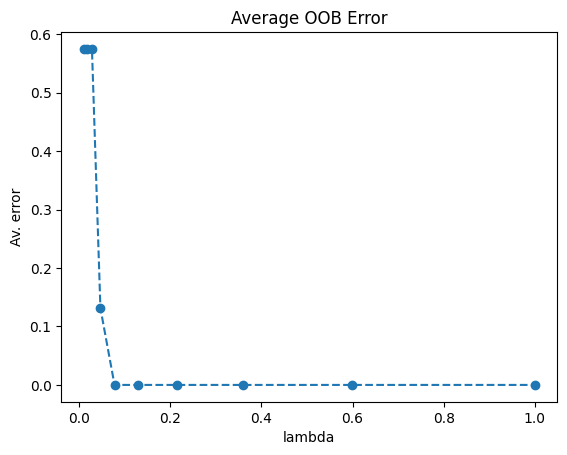

In [14]:
plt.close()
plt.figure()
plt.plot(lambdas,np.mean(errors,0),marker='o', linestyle='--')
plt.xlabel('lambda')
plt.ylabel('Av. error')
plt.title('Average OOB Error')
plt.show()

In [15]:
for k in range(num_lambdas):
    res=st.confidenceIntervals(Z[k,:,:],alpha=0.05) ## we get the confidence intervals using the stability package
    stabilities[k]=res['stability']
    errStab[k]=stabilities[k]-res['lower']

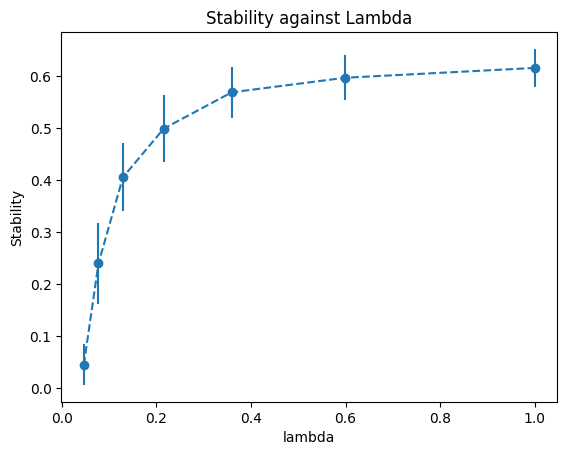

In [16]:
plt.close()
plt.figure()
plt.errorbar(lambdas,stabilities,yerr=errStab,marker='o', linestyle='--')
plt.xlabel('lambda')
plt.ylabel('Stability')
plt.title('Stability against Lambda')
plt.show()

In [17]:
best_stability_index = np.nanargmax(stabilities)
gridsearch_index = np.where(lambdas == gridsearch_classifier.best_params_['C'])[0][0]

print(f"--- lambda = {lambdas[best_stability_index]} ---")
print(f'Stability is maximal = {round(stabilities[best_stability_index]*100,2)}%. \nAverage Number of features selected for this lambda across {M} iterations is {np.mean(numFeatSelected[best_stability_index])}. \nAverage OOB error is {np.mean(errors[best_stability_index])}')
print('\n')
print(f"--- lambda (grid search) = {gridsearch_classifier.best_params_['C']} ---")
print(f'Stability = {round(stabilities[gridsearch_index]*100,2)}%. \nAverage Number of features selected for this lambda across {M} iterations is {np.mean(numFeatSelected[gridsearch_index])}. \nAverage OOB error is {np.mean(errors[gridsearch_index])}')

--- lambda = 1.0 ---
Stability is maximal = 61.64%. 
Average Number of features selected for this lambda across 10 iterations is 177.8. 
Average OOB error is 0.21428571428571427


--- lambda (grid search) = 0.0774263682681127 ---
Stability = 23.98%. 
Average Number of features selected for this lambda across 10 iterations is 189.1. 
Average OOB error is 0.16666666666666669


As we can see from these figures, the value of the regularizing parameter that yields the maximal stability (out of the 10 regularizing parameters chosen) is not the one yielding the minimum error. Here, a trade-off between error and stability needs to chosen.
Nevertheless, we can see that making a small sacrife in terms of accuracy can largely improve stability.

### Feature occurrence as a measure of stability

If you ran your feature selection algorithm multiple times with different (bootstrapped) samples, you could additionally derive some other statistics as a measure for the robustnes of the algorithm. For example, for each feature, we can check how many times it was chosen across iterations.

We will showcase this for both of the lambdas - one chosen via grid search (maximizing accuracy) and one chosen as a trade-off between stability and accuracy. We will use the same matrix Z formed during the iterations.

In [18]:
feature_count_max_stability = Z_dict[lambdas[best_stability_index]]
feature_count_max_accuracy = Z_dict[lambdas[gridsearch_index]]

In [24]:
chosen_per_feature_stability = pd.DataFrame(feature_count_max_stability.sum(axis=0)).reset_index()
chosen_per_feature_stability.columns = ['feature', 'count']
chosen_per_feature_stability.sort_values('count',inplace=True, ascending=False)
chosen_per_feature_stability

,feature,count
7234,Solyc05g007540.1.1,10
17011,Solyc04g082360.1.1,10
20581,Solyc04g024960.1.1,10
10109,Solyc00g017540.1.1,10
19956,Solyc07g017690.2.1,10
...,...,...
9697,Solyc03g083040.1.1,0
9696,Solyc01g080380.2.1,0
9695,Solyc08g036640.2.1,0
9694,Solyc02g086190.1.1,0


<Axes: title={'center': 'Number of times a feature was chosen across iterations.\nLambda chosen with maximal stability'}, ylabel='feature'>

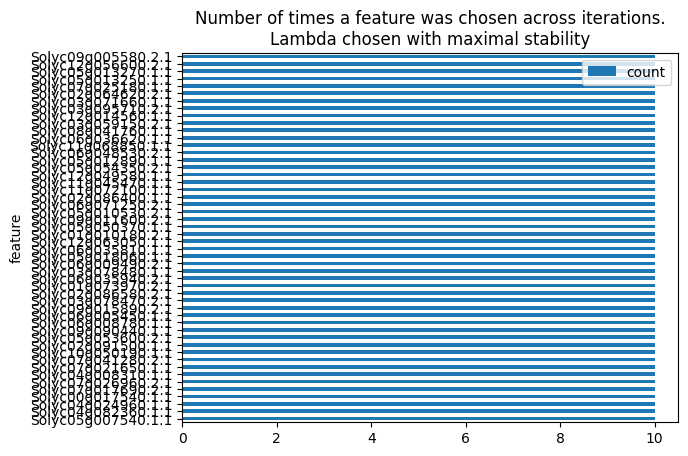

In [21]:
chosen_per_feature_stability = pd.DataFrame(feature_count_max_stability.sum(axis=0)).reset_index()
chosen_per_feature_stability.columns = ['feature', 'count']
chosen_per_feature_stability.sort_values('count',inplace=True, ascending=False)
chosen_per_feature_stability.iloc[:50,].plot.barh(y='count', x='feature', title='Number of times a feature was chosen across iterations.\nLambda chosen with maximal stability')

In [34]:
chosen_per_feature_stability['count'].value_counts().sort_index()

0     26624
1       590
2       262
3       157
4       101
5        87
6        65
7        59
8        70
9        81
10      202
Name: count, dtype: int64

<Axes: title={'center': 'Number of times a feature was chosen across iterations.\nLambda chosen with maximal accuracy'}, ylabel='feature'>

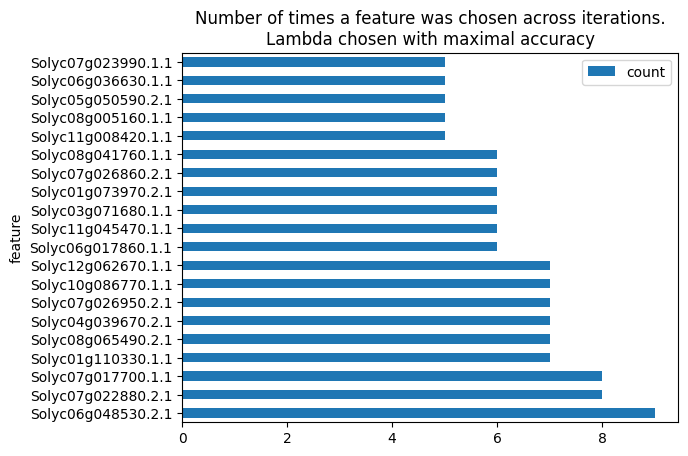

In [26]:
chosen_per_feature_accuracy = pd.DataFrame(feature_count_max_accuracy.sum(axis=0)).reset_index()
chosen_per_feature_accuracy.columns = ['feature', 'count']
chosen_per_feature_accuracy.sort_values('count',inplace=True, ascending=False)
chosen_per_feature_accuracy.iloc[:20,].plot.barh(y='count', x='feature', title='Number of times a feature was chosen across iterations.\nLambda chosen with maximal accuracy')

In [35]:
chosen_per_feature_accuracy['count'].value_counts().sort_index()

0    27945
1      202
2       57
3       39
4       28
5       12
6        6
7        6
8        2
9        1
Name: count, dtype: int64

TODO: explain - for the lambda with max accuracy we don't even have a single feature that was chosen across all iterations whereas for the lambda with max stability we have much more(could be due to collinearity, though!)

## Potential next steps

Now that we analysed which hyperparameter(s) might be good for fitting our model and what is the effect of it on the stability, we can choose how to proceed with the analysis. This, of course, depends on our goal and we will cover two possible options:

1. You wish to have a trained model with coefficients that you want to reuse on the unseen data
2. You wish to decide on the final reduced set of features that will enter some other statistical analysis (e.g. the set of chosen genes will be selected for further inspection to seach for clinical signal or a doctor should pay extra attention to selected variables when assessing the patient.)

### Option 1 - training the model by using newly gained knowledge

Now that we know much more about the effect of the regularization parameter on both accuracy and stability of the model and feature selection, we need to decide whether we are ready to accept the aforementioned trade-off between accuracy and stability, i.e., decide if we want to lose a bit of accuracy for the sake of more stable model.
...TBA...

In [ ]:
# # Train test split
# X_train, X_test, y_train, y_test = train_test_split(
#     data_model.drop(columns=[target], axis=1),
#     data_model[target], stratify = data_model[target],
#     test_size=0.2,
#     random_state=444)

# # Train - validation split
# X_train, X_valid, y_train, y_valid = train_test_split(
#     X_train,
#     y_train, stratify = y_train,
#     test_size=0.2,
#     random_state=234)

# print(f"X train: {X_train.shape}, X test: {X_test.shape}, X valid: {X_valid.shape}")
# print(f"y train: {y_train.shape}, y test: {y_test.shape}, y valid: {y_valid.shape}")
# print(f"y train values: {np.unique(y_train, return_counts=True)}")
# print(f"y test values: {np.unique(y_test, return_counts=True)}")

# # Encode labels
# encoder = LabelEncoder()
# y_train = encoder.fit_transform(y_train)
# y_test = encoder.transform(y_test)

# print("Encoding check:")
# print(np.unique(y_train, return_counts=True))
# print(np.unique(y_test, return_counts=True))

# # Scale the data
# scaler = StandardScaler()
# X_train_transformed = scaler.fit_transform(X_train)
# X_test_transformed = scaler.transform(X_test)
# X_valid_transformed = scaler.transform(X_valid)


In [ ]:
# # Define a model
# model = LogisticRegression(penalty = 'elasticnet', 
#                            solver = 'saga', 
#                            l1_ratio = 0.5, 
#                            C = lambdas[best_index], 
#                            max_iter=1000, 
#                            random_state=12345)

# model_grid = LogisticRegression(penalty = 'elasticnet', 
#                                 solver = 'saga', 
#                                 l1_ratio = 0.5, 
#                                 C = lambdas[gridsearch_index],
#                                 max_iter=1000, 
#                                 random_state=12345)

In [ ]:
# oob_scorer = lambda y_test, y_pred: 1-accuracy_score(y_test, y_pred)
# my_scorer = make_scorer(oob_scorer, greater_is_better=False) # Smaller OOB error means better model

# # Run cross_val_score
# print(f"Average accuracy across 4-fold cv: {round(np.mean(cross_val_score(model, X_train_transformed, y_train, 
#                                                                           cv=4, scoring='accuracy'))*100,2)}%")

What if we fit with the grid-search index?

In [ ]:
# oob_scorer = lambda y_test, y_pred: 1-accuracy_score(y_test, y_pred)
# my_scorer = make_scorer(oob_scorer, greater_is_better=False) # Smaller OOB error means better model

# # Run cross_val_score
# print(f"Average accuracy across 4-fold cv: {round(np.mean(cross_val_score(model_grid, X_train_transformed, y_train,
#                                                                           cv=4, scoring='accuracy'))*100,2)}%")


### Option 2 - selecting final set of features

Stability selector paper: 

**set of stable features** = set of all the features having a frequency of selection higher than some user defined threshold for __at least__ one of the regularizing parameteres lambda from lambdas

Other options - for chosen lambda, select the treshold and take the features above it...


TODO - decide what and how to present

In [36]:
for i in range(len(lambdas)):
    Z_i = Z_dict[lambdas[i]]
    if i==0:
        count_per_feature = pd.DataFrame(Z_i.sum(axis=0), columns=['lambda_'+str(i)])
    else:
        count_per_feature = pd.concat([count_per_feature, pd.DataFrame(Z_i.sum(axis=0), columns=['lambda_'+str(i+1)])], axis=1)
count_per_feature['total'] = count_per_feature.sum(axis=1)
count_per_feature.sort_values(by='total', ascending=False, inplace=True)

In [37]:
count_per_feature

,lambda_0,lambda_2,lambda_3,lambda_4,lambda_5,lambda_6,lambda_7,lambda_8,lambda_9,lambda_10,total
Solyc06g048530.2.1,0,0,0,1,9,10,10,10,10,10,60
Solyc07g017700.1.1,0,0,0,2,8,10,10,10,10,10,60
Solyc07g022880.2.1,0,0,0,0,8,10,10,10,10,10,58
Solyc01g110330.1.1,0,0,0,2,7,9,9,10,10,10,57
Solyc08g065490.2.1,0,0,0,0,7,10,10,10,10,10,57
...,...,...,...,...,...,...,...,...,...,...,...
Solyc03g083040.1.1,0,0,0,0,0,0,0,0,0,0,0
Solyc01g080380.2.1,0,0,0,0,0,0,0,0,0,0,0
Solyc08g036640.2.1,0,0,0,0,0,0,0,0,0,0,0
Solyc02g086190.1.1,0,0,0,0,0,0,0,0,0,0,0


In [38]:
# Set the threshold - percentage of M
threshold = int(0.9*M)
threshold

9

In [39]:
final_feature_set = []
for i in range(count_per_feature.shape[0]):
    if (count_per_feature.iloc[i,:count_per_feature.shape[1]-1] >= threshold).any() == True:
        final_feature_set.append(count_per_feature.index[i])

In [40]:
#final_feature_set = list(count_per_feature.index[np.where(count_per_feature['total'] >= threshold)[0]])
print(f"There are {len(final_feature_set)} features in the final feature set, based on a threshold of {threshold}:\n")
print(*final_feature_set, sep='\n')

There are 283 features in the final feature set, based on a threshold of 9:

Solyc06g048530.2.1
Solyc07g017700.1.1
Solyc07g022880.2.1
Solyc01g110330.1.1
Solyc08g065490.2.1
Solyc12g062670.1.1
Solyc10g086770.1.1
Solyc07g026950.2.1
Solyc04g039670.2.1
Solyc04g005540.2.1
Solyc06g035940.2.1
Solyc06g017860.1.1
Solyc11g045470.1.1
Solyc11g008420.1.1
Solyc07g026860.2.1
Solyc03g034200.2.1
Solyc02g075610.2.1
Solyc11g045480.1.1
Solyc01g073970.2.1
Solyc07g021650.1.1
Solyc06g036630.1.1
Solyc05g050590.2.1
Solyc06g050320.2.1
Solyc12g049580.1.1
Solyc08g041760.1.1
Solyc05g015730.1.1
Solyc06g054550.2.1
Solyc06g036620.1.1
Solyc05g050370.1.1
Solyc12g042240.1.1
Solyc10g005120.1.1
Solyc07g023990.1.1
Solyc07g032080.2.1
Solyc04g055060.1.1
Solyc08g015650.2.1
Solyc12g088180.1.1
Solyc03g059150.2.1
Solyc05g013260.1.1
Solyc08g065310.2.1
Solyc03g071680.1.1
Solyc00g017540.1.1
Solyc07g017710.1.1
Solyc05g013250.1.1
Solyc03g116820.2.1
Solyc03g079970.1.1
Solyc01g009840.1.1
Solyc07g008970.2.1
Solyc04g015500.2.1
Solyc08g013

TODO - address overfitting! Correlations?